## Sagnac Frequency - Backscatter Correction - Overview

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.cc_lag_matrix import __cc_lag_matrix
# from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [22]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

case = 10
# config['tbeg'] = UTCDateTime("2023-12-05 00:00")
# config['tend'] = UTCDateTime("2023-12-16 00:00")

config['tbeg'] = UTCDateTime("2023-12-08 00:00")
config['tend'] = UTCDateTime("2023-12-15 00:00")
flim1, flim2 = 302.425, 302.485

## note air ventilation on from 27-12-2023 !!!
# case = 11
# config['tbeg'] = UTCDateTime("2023-12-24 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")

# case = 12
# config['tbeg'] = UTCDateTime("2024-01-06 00:00")
# config['tend'] = UTCDateTime("2024-01-26 00:00")
# flim1, flim2 = 302.375, 302.475

# case = 13
# config['tbeg'] = UTCDateTime("2024-02-08 07:00")
# config['tend'] = UTCDateTime("2024-02-13 05:00")
# flim1, flim2 = 302.395, 302.45

# case = 14
# config['tbeg'] = UTCDateTime("2024-02-15 18:00")
# config['tend'] = UTCDateTime("2024-02-18 16:00")
# flim1, flim2 = 302.395, 302.45

case = 16
config['tbeg'] = UTCDateTime("2024-02-24 00:00")
config['tend'] = UTCDateTime("2024-03-10 00:00")
flim1, flim2 = 302.40, 302.47


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [23]:
def __load_backscatter_data(tbeg, tend, ring, path_to_data):

    from os.path import isfile
    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)+86400).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        # print(dat)
        dat_str = str(dat)[:10].replace("-", "")
        file = f"FJ{ring}_{dat_str}_backscatter.pkl"

        if not isfile(path_to_data+file):
            _path = data_path+"sagnac_frequency/data/"

            out = DataFrame()
            for m in range(24):
                hour = str(m).rjust(2, '0')+":00:00"
                filename = f"FJU_{dat_str}_{hour}_backscatter.pkl"
                try:
                    _df = read_pickle(_path+filename)
                    out = concat([out, _df])
                except:
                    print(f" -> failed: {_path}{filename}")
                    continue

            if not out.empty:
                print(f" -> write to: {_path}backscatter/FJU_{dat_str}_backscatter.pkl")
                out.to_pickle(f"{_path}backscatter/FJU_{dat_str}_backscatter.pkl")
            else:
                continue

        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to time interval
    df = df[df.time1 >= tbeg]
    df = df[df.time2 <= tend]

    df.reset_index(inplace=True)

    return df

In [24]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])


# apply backscatter correction
# bs['fj_bs'] = bs.fj_fs * bs.term

# add seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

 -> write to: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/FJU_20240306_backscatter.pkl
 -> write to: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/FJU_20240307_backscatter.pkl
 -> write to: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/FJU_20240308_backscatter.pkl
 -> write to: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/FJU_20240309_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJU_20240310_23:00:00_backscatter.pkl
 -> write to: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/FJU_20240310_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJU_20240311_00:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJU_20240311_01:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJU_20240311_02:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJU_20240311_03:00:00_backscatter

In [25]:
def __backscatter_correction(m01, m02, phase0, w_obs, nominal_sagnac, cm_filter_factor=1.033):

    ## Correct for bias
    m1 = m01 * ( 1 + m01**2 / 4 )
    m2 = m02 * ( 1 + m02**2 / 4 )

    ## angular correction for phase
    phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

    ## compute squares of common-mode modulations
    m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

    ## compute squares of differential-mode modulations
    m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

    ## correct m2c for gain saturation of a HeNe laser
    # m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
    m2c = m2c * cm_filter_factor

    ## compute backscatter correction factor
    M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

    ## correction term
    term = ( 4 + M ) / ( 4 - M )

    ## backscatter correction
    # BScorrection = -1 * ( term - 1 ) * nominal_sagnac
    # w_corrected = np.array(w_obs) + BScorrection

    w_corrected = np.array(w_obs) * term

    return w_corrected

In [26]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, 303.05, cm_filter_factor=1.033)

### Cut corrupt data periods

In [27]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     # bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     # bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

(302.4, 302.47)

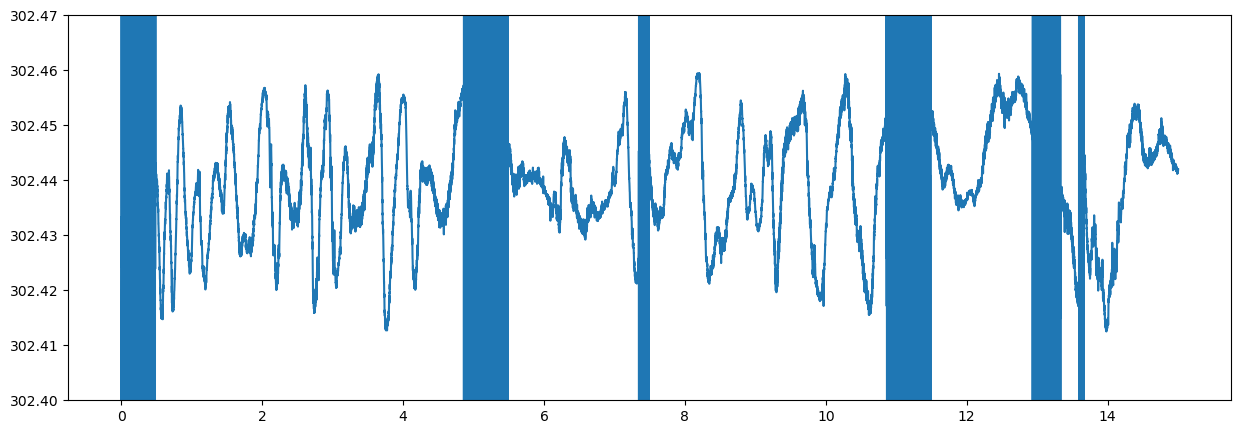

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Load Maintenance Log

In [21]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [383]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Load MLTI Log

In [384]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [385]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [386]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN


for key in ["fj_fs", "fj_bs", "f1_fs", "f2_fs", "f1_ac", "f2_ac", "f1_dc", "f2_dc", "f1_ph", "f2_ph"]:
    bs = __mlti_intervals_to_NaN(bs, key, "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)


### Apply Selections

In [387]:
# tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
# cond1 = bs.time1 > tt1
# cond2 = bs.time1 < tt2
# cond3 = bs.fj_fs_nan < 302.4
# cond4 = bs.fj_fs_nan > 302.6

# bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
# bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

# bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
# bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [388]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [389]:
from functions.smoothing import __smooth

n_minutes = 180

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

/tmp/ipykernel_959386/4063111886.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


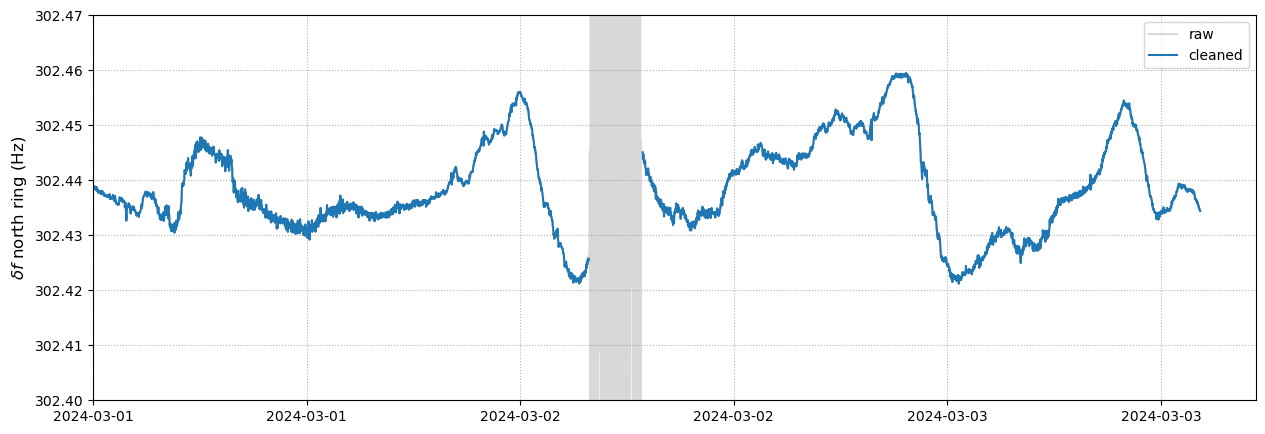

In [390]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)


    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


## Overview Plot

In [391]:
bs.keys()

Index(['index', 'time1', 'time2', 'fj_fs', 'fj_ac', 'fj_dc', 'fj_ph', 'f1_fs',
       'f1_ac', 'f1_dc', 'f1_ph', 'f2_fs', 'f2_ac', 'f2_dc', 'f2_ph', 'w_s',
       'bscorrection', 'term', 'time_sec', 'fj_bs', 'fj_fs_nan', 'fj_bs_nan',
       'f1_fs_nan', 'f2_fs_nan', 'f1_ac_nan', 'f2_ac_nan', 'f1_dc_nan',
       'f2_dc_nan', 'f1_ph_nan', 'f2_ph_nan', 'fj_fs_inter', 'fj_bs_inter',
       'fj_fs_smooth', 'fj_bs_smooth'],
      dtype='object')

/tmp/ipykernel_959386/2824993535.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


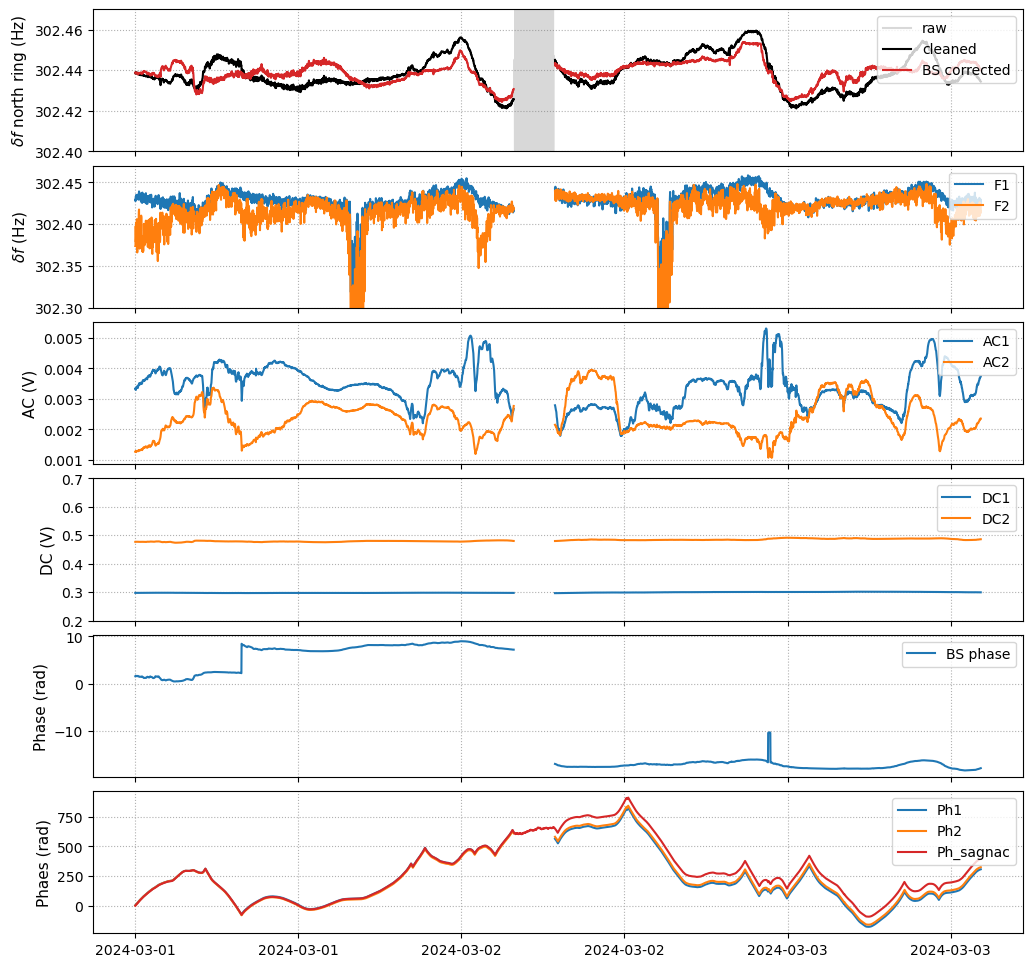

In [395]:
def __makeplot_sagnac_overview():

    Nrow, Ncol = 6, 1

    font = 11

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ref_date = str(bs.time1.iloc[0])[:10]

    ## -----------------------------------------------------------------------------

    ax[0].plot(bs.time_sec, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec, bs.fj_bs_nan, color="tab:red", label="BS corrected")

    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ## -----------------------------------------------------------------------------

    ax[1].plot(bs.time_sec, bs.f1_fs_nan, color="tab:blue", label="F1")
    ax[1].plot(bs.time_sec, bs.f2_fs_nan, color="tab:orange", label="F2")

    ax[1].set_ylim(flim1-0.1, flim2)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("$\delta f$ (Hz)", fontsize=font)



    ## -----------------------------------------------------------------------------

    ax[2].plot(bs.time_sec, bs.f1_ac_nan, color="tab:blue", label="AC1")
    ax[2].plot(bs.time_sec, bs.f2_ac_nan, color="tab:orange", label="AC2")

    ax[2].set_ylabel("AC (V)", fontsize=font)


    ## -----------------------------------------------------------------------------

    ax[3].plot(bs.time_sec, bs.f1_dc_nan, color="tab:blue", label="DC1")
    ax[3].plot(bs.time_sec, bs.f2_dc_nan, color="tab:orange", label="DC2")

    ax[3].set_ylabel("DC (V)", fontsize=font)
    ax[3].set_ylim(0.2, 0.7)

    ## -----------------------------------------------------------------------------

    ax[4].plot(bs.time_sec, bs.f1_ph_nan-bs.f2_ph_nan, color="tab:blue", label="BS phase")
    # ax[4].set_ylim(-12, 12)

    ax[4].set_ylabel("Phase (rad)", fontsize=font)

    ## -----------------------------------------------------------------------------

    ax[5].plot(bs.time_sec, bs.f1_ph_nan, color="tab:blue", label="Ph1")
    ax[5].plot(bs.time_sec, bs.f2_ph_nan, color="tab:orange", label="Ph2")
    ax[5].plot(bs.time_sec, bs.fj_ph, color="tab:red", label="Ph_sagnac")

    ax[5].set_ylabel("Phaes (rad)", fontsize=font)

    for _k in range(Nrow):
        ax[_k].grid(ls=":", zorder=0)
        ax[_k].legend(loc=1)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        for _n in range(Nrow):
            ax[_n].fill_betweenx([ax[_n].get_ylim()[0], ax[_n].get_ylim()[1]], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    plt.show();
    return fig

fig = __makeplot_sagnac_overview();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Compute PSD

/tmp/ipykernel_959386/4031747786.py:53: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 1e-3)
/tmp/ipykernel_959386/4031747786.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)


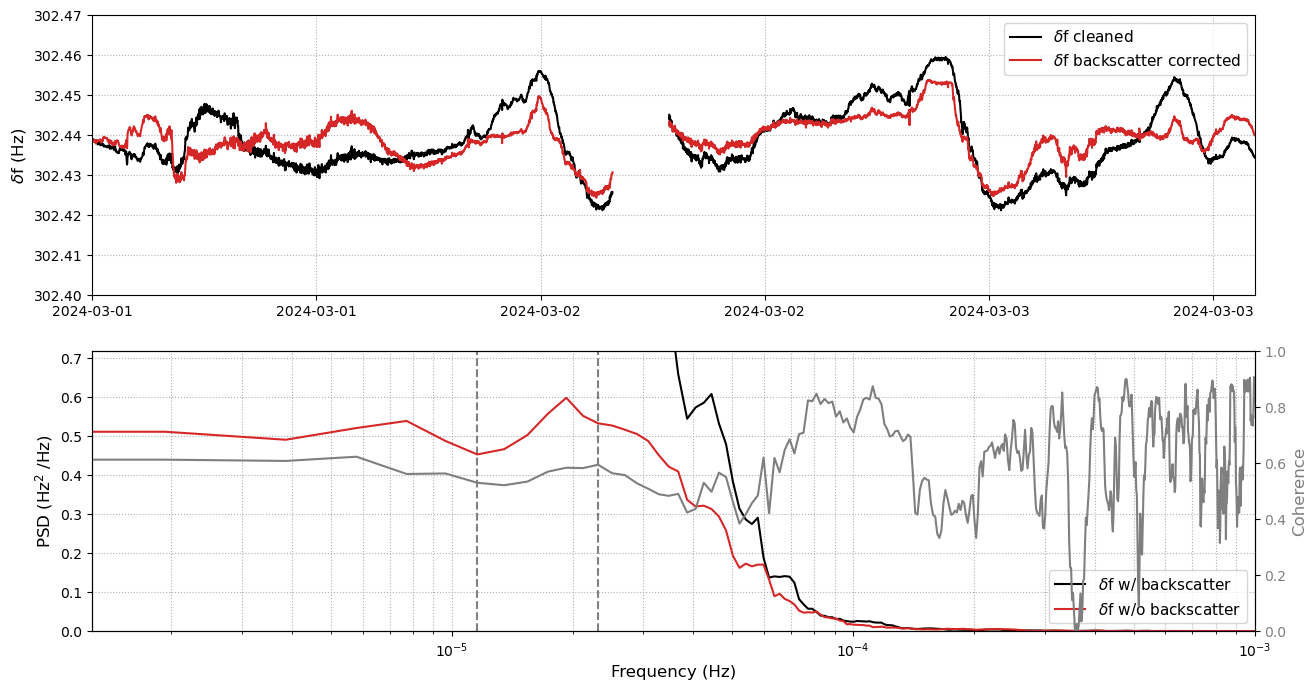

In [393]:
def __makeplot(key1, key2, fft=False):

    dat1 = np.array((bs[key1] - bs[key1].mean()).replace(np.nan, 0))
    dat2 = np.array((bs[key2] - bs[key2].mean()).replace(np.nan, 0))


    out = __multitaper_coherence(dat1, dat2, 60, n_taper=10, time_bandwidth=3.5, method=0)


    f1, psd1, pha1 = __get_fft(dat1, 60)
    f2, psd2, pha2 = __get_fft(dat2, 60)


    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))


    ax[0].plot(bs.time_sec*time_scaling, bs[key1], color="black", label=f"$\delta$f cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs[key2], color="tab:red", label=f"$\delta$f backscatter corrected")

    ax[0].ticklabel_format(useOffset=False)

    if fft:
        ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f cleaned")
        ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f backscatter corrected")
        ax[1].set_ylim(0, max(psd1)+0.2*max(psd1))
        ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    else:
        ax[1].semilogx(out['ff1'], out['psd1'], color="black", label=f"$\delta$f w/ backscatter")
        ax[1].semilogx(out['ff2'], out['psd2'], color="tab:red", label=f"$\delta$f w/o backscatter")
        ax[1].set_ylim(0, max(out['psd2'])*1.2)
        ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.semilogx(out['fcoh'], out['coh'], color="tab:grey", label=f"coherence")
    ax11.set_ylim(0, 1.)
    ax11.set_ylabel(f"Coherence", fontsize=font, color="tab:grey")
    [t.set_color('tab:grey') for t in ax11.yaxis.get_ticklabels()]

    for _n in range(Nrow):
        ax[_n].grid(which="both", ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    # ax[0].set_ylim(302.395, 302.465)
    ax[0].set_ylim(flim1, flim2)
    ax[0].set_xlim(0, max(bs.time_sec)*time_scaling)

    ax[1].set_xlim(0, 1e-3)

    ax[1].legend(loc=4, fontsize=font-1)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    # ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax[0].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[0].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("fj_fs_nan", "fj_bs_nan", fft=False);
# fig = __makeplot("fj_fs_inter", "w_s_inter");

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_PSD_inter.png", format="png", dpi=150, bbox_inches='tight')


## Load Pressure Data

In [22]:
ps = __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LDI", config['tbeg'], config['tend'])
# ws = __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LDI", config['tbeg'], config['tend'])

# ps = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])

In [23]:
ps

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-02-20T00:00:00.000000Z - 2024-03-03T00:00:00.000000Z | 1.0 Hz, 1036801 samples

In [24]:
for tr in ps:
    tr.data = __interpolate_nan(tr.data)
    if "PROMY" in tr.stats.station and "D" in tr.stats.channel:
        tr.data /= 100

    # tr.data = np.gradient(tr.data)
ps

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-02-20T00:00:00.000000Z - 2024-03-03T00:00:00.000000Z | 1.0 Hz, 1036801 samples

In [83]:
tr00 = Trace()
tr00.data = np.array(bs.fj_bs_inter)
tr00.stats.delta = 60
tr00.stats.starttime = bs.time1[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "U"

st = Stream()
st += tr00.copy()
st += ps[0].copy()

st = st.detrend("simple")
st = st.filter("lowpass", freq = 0.005, corners=4, zerophase=True)
st = st.resample(0.01, no_filter=True)

st

2 Trace(s) in Stream:
BW.ROMY.U.      | 2024-02-20T00:00:00.000000Z - 2024-03-02T23:58:20.000000Z | 100.0 s, 10368 samples
BW.PROMY.03.LDI | 2024-02-20T00:00:00.000000Z - 2024-03-02T23:58:20.000000Z | 100.0 s, 10368 samples

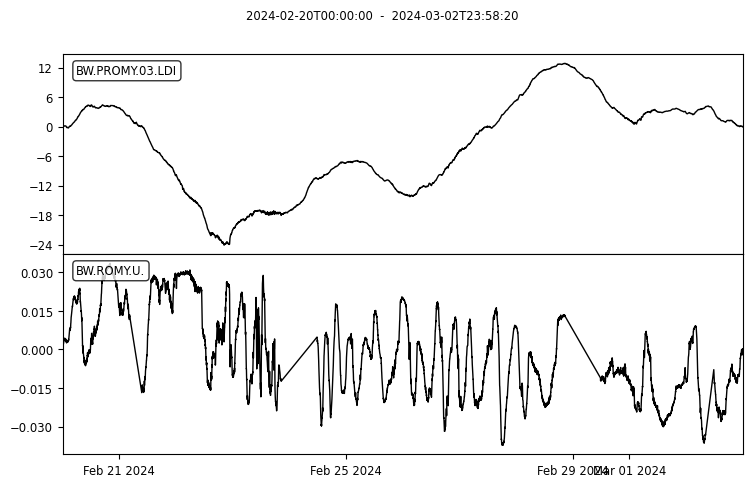

In [35]:
st.plot(equal_scale=False);

0.004840066545971956


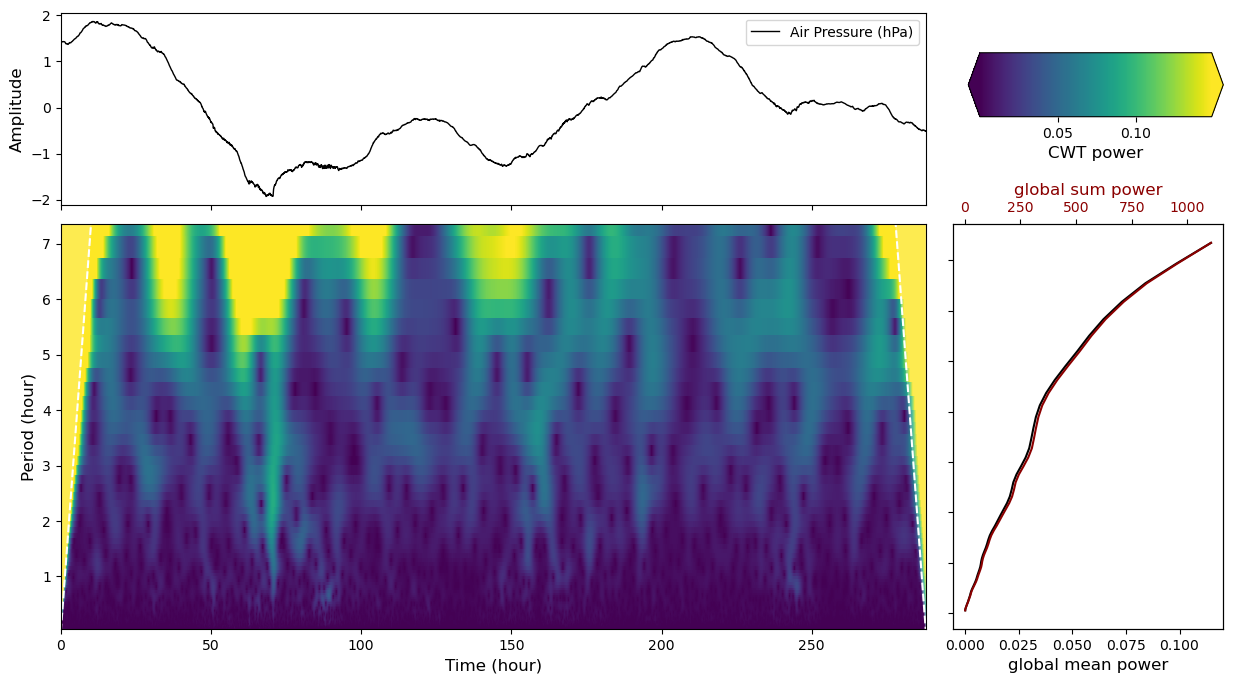

In [36]:
ttt = st[1].times()
arr = st[1].data
dt  = st[1].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="Air Pressure (hPa)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_2.png", format="png", dpi=200, bbox_inches='tight')


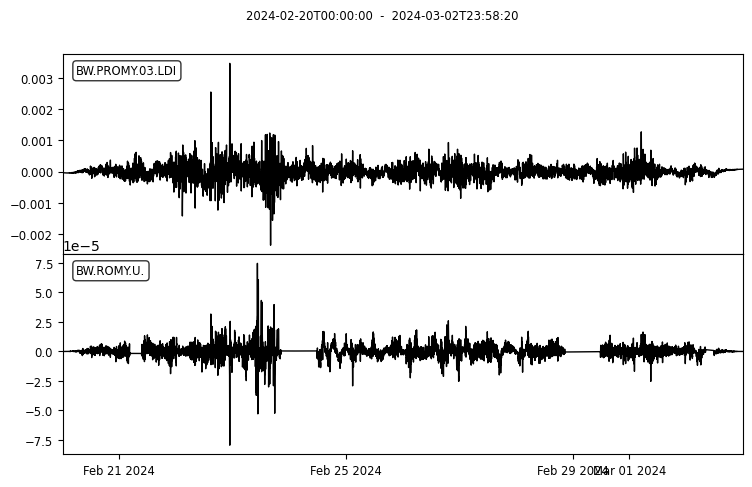

In [70]:
lp = st.copy()

lp = lp.detrend("simple")
lp = lp.taper(0.1)
# lp = lp.filter("bandpass", freqmin=1/(12*3600), freqmax=1/(1*3600), corners=4, zerophase=True)
lp = lp.filter("highpass", freq=1/(48*3600), corners=4, zerophase=True)
# lp = lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)

lp.plot(equal_scale=False);

/tmp/ipykernel_959386/2093092059.py:19: RuntimeWarning: divide by zero encountered in divide
  ax[0].semilogx(1/out['fcoh'], out['coh'])
/tmp/ipykernel_959386/2093092059.py:21: RuntimeWarning: divide by zero encountered in divide
  ax[1].semilogx(1/out['ff1'], out['psd1'])
/tmp/ipykernel_959386/2093092059.py:22: RuntimeWarning: divide by zero encountered in divide
  ax[2].semilogx(1/out['ff2'], out['psd2'])
/tmp/ipykernel_959386/2093092059.py:25: RuntimeWarning: divide by zero encountered in divide
  ax11.semilogx(1/f1, psd1, color="tab:orange")
/tmp/ipykernel_959386/2093092059.py:28: RuntimeWarning: divide by zero encountered in divide
  ax22.semilogx(1/f2, psd2, color="tab:orange")


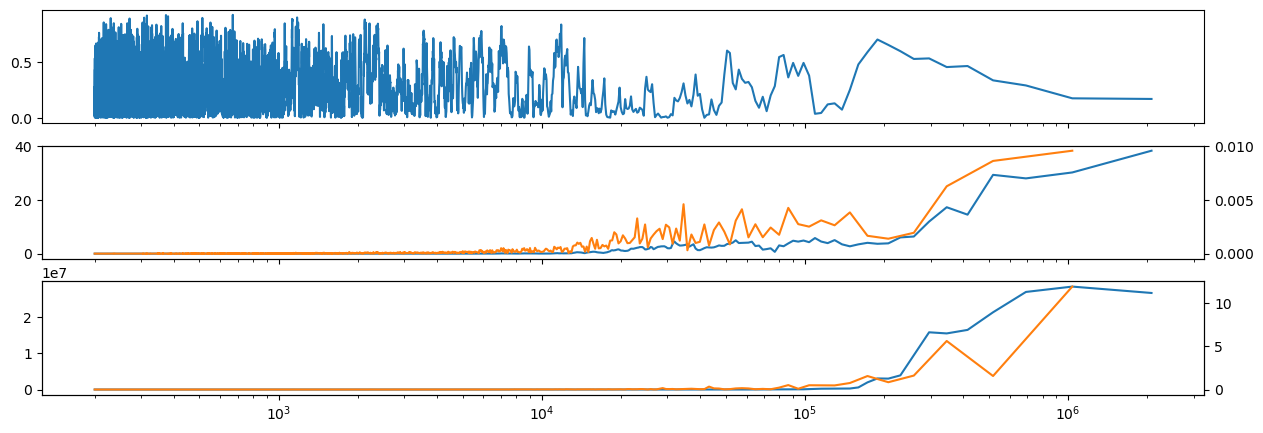

In [71]:
# dat1 = lp[0].data
# dat2 = lp[1].data
# dt, df = lp[0].stats.delta, lp[0].stats.delta

dat1 = st[0].data
dat2 = st[1].data
dt, df = st[0].stats.delta, st[0].stats.delta

out = __multitaper_coherence(dat1, dat2, dt, n_taper=5, time_bandwidth=3.5, method=2)


f1, psd1, pha1 = __get_fft(dat1, dt)
f2, psd2, pha2 = __get_fft(dat2, dt)



fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

ax[0].semilogx(1/out['fcoh'], out['coh'])

ax[1].semilogx(1/out['ff1'], out['psd1'])
ax[2].semilogx(1/out['ff2'], out['psd2'])

ax11 = ax[1].twinx()
ax11.semilogx(1/f1, psd1, color="tab:orange")

ax22 = ax[2].twinx()
ax22.semilogx(1/f2, psd2, color="tab:orange")

plt.show();

In [72]:
# from scipy.signal import hilbert

# env0 = abs(hilbert(lp[0].data))
# env1 = abs(hilbert(lp[1].data))

# # plt.plot(env0)
# # plt.plot(env1*0.05)

# plt.plot(__smooth(env0, 200))
# plt.plot(__smooth(env1*0.01, 200))

In [73]:
def __cross_correlation_function_windows(arr1, arr2, dt, Twin, overlap=0, demean=True):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import arange, array, roll

    N = len(arr1)
    n_interval = int(Twin/dt)
    n_overlap = int(overlap*Twin/dt)

    # time = arange(0, N*dt, dt)

    times, samples = [], []
    n1, n2 = 0, n_interval
    while n2 <= N:
        samples.append((n1, n2))
        times.append(int(n1+(n2-n1)/2)*dt)
        n1 = n1 + n_interval - n_overlap
        n2 = n2 + n_interval - n_overlap

    cc, mm, ss = [], [], []
    for _n, (n1, n2) in enumerate(samples):

        _arr1 = arr1[n1:n2]
        _arr2 = arr2[n1:n2]

        num = len(_arr1)

        ccf = correlate(_arr1, _arr2, num, demean=demean, normalize='naive', method='fft')
        shift, val = xcorr_max(ccf)

        cc.append(ccf)
        mm.append(val)
        ss.append(shift)

    tlags = arange(-num*dt, num*dt+1, dt)

    return array(times), array(cc), tlags, array(ss), array(mm)

In [74]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data
# dat2 = np.roll(lp[0].data,50)


twin = 6*3600

ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(dat1, dat2, dt, twin, overlap=0.5, demean=True)



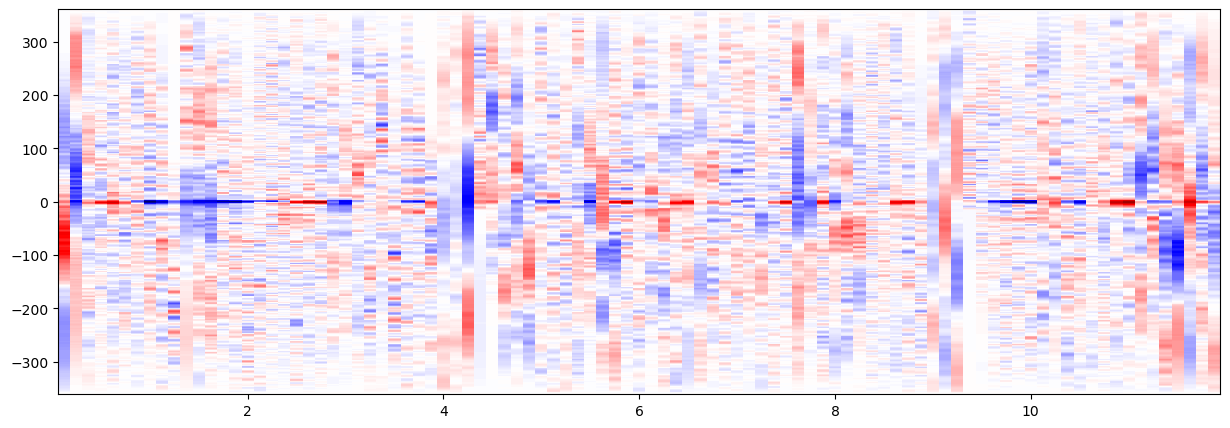

In [75]:
plt.figure(figsize=(15, 5))

cmap = plt.get_cmap("seismic")

plt.pcolormesh(ttt/86400, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)

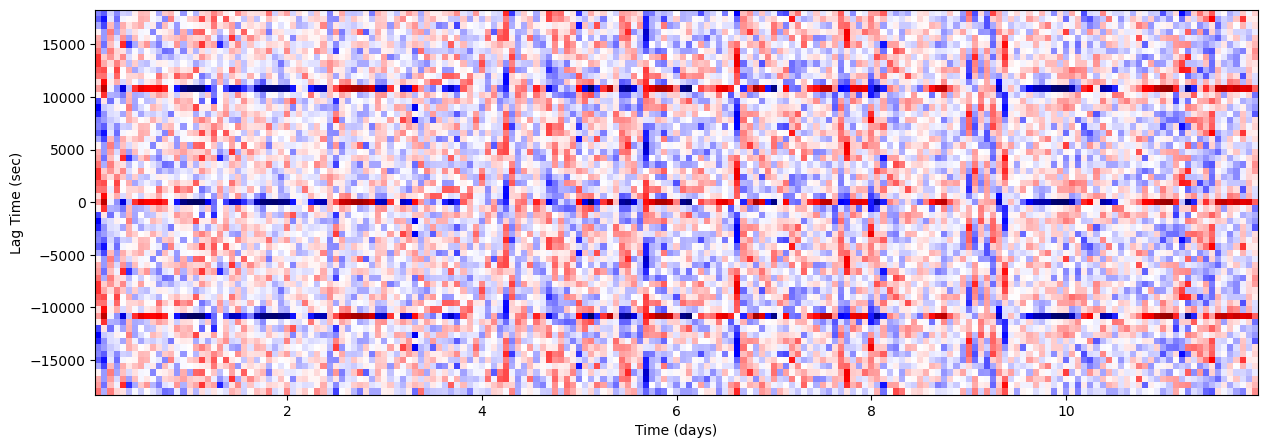

In [76]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data

twin = 3*3600


tt, Tlags, ccc = __cc_lag_matrix(dat1, dat2, dt, twin, 5*3600, 600, plot=True)


### Convert beat to tilt

$\delta$ f = S * $\Omega_E$ * sin($\phi_{lat}$ + $\theta_{dip}$ + $\epsilon_{tilt}$)

$\epsilon_{tilt}$ = arcsin( $\delta$ f / S / $\Omega_E$ ) - $\phi_{lat}$ - $\theta_{dip}$

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [ ]:
# def __to_tilt(data):

#     from numpy import pi, sqrt, arccos, deg2rad, arcsin

#     dip = 109.5
#     L = 12.0
#     S = (np.sqrt(3)*L)/(3*632.8e-9)
#     lat = 48.162941
#     omegaE = 2*np.pi/86400

#     return arcsin(data /omegaE /S) - deg2rad(lat) - deg2rad(dip)

In [ ]:
def __conversion_to_tilt(st, conf):

    st0 = st.copy()

    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")

    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [ ]:
fs_tilt = __sagnac_to_tilt(bs.w_s_inter, "U")

plt.plot(fs_tilt)

### Load Tilt Data

In [ ]:
# tromy0 =  __read_sds(config['path_to_sds'], "BW.TROMY..MAN", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.TROMY..MAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.TROMY..MAT", config['tbeg']-600, config['tend']+600)

# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

# tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

# tromy = tromy0.copy();

# tromy = tromy.merge();

# tromy.plot(equal_scale=False);

### LowPass Version

In [ ]:
tromy_lp = tromy0.copy()
tromy_lp = tromy_lp.detrend("simple")
tromy_lp = tromy_lp.taper(0.1)
# tromy_lp = tromy_lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)
tromy_lp = tromy_lp.filter("bandpass", freqmin=1/(10*86400), freqmax=1/(1*3600), corners=4, zerophase=True)
tromy_lp = tromy_lp.resample(1/(1*3600), no_filter=True)

tromy_lp.merge()
tromy_lp.plot(equal_scale=False);

In [ ]:
gc.collect()

In [ ]:
from obspy.signal.cross_correlation import correlate, xcorr_max

arr1 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)

# arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
# arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

Nshift = len(arr1)
ccf = correlate(arr1, arr2, shift=Nshift, demean=True, normalize='naive', method='fft')
cclags = np.arange(-Nshift, Nshift+1)

shift, value = xcorr_max(ccf)
print("Nshift: ", shift, "Tshift: ", shift*tromy_lp[0].stats.delta, "CC: ", value)

cclag = shift

plt.plot(cclags, ccf)

In [ ]:
arr1 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)


fig, ax = plt.subplots(4, 1, figsize=(15, 8))

ax[0].plot(arr1, label="tilt")
ax[0].plot(-arr2*1e-5, label="-1 temperature")
correct = np.roll(arr2, -cclag)
ax[0].plot(-correct*1e-5, label="shifted -1 temperature")

ax[0].legend()

ax[1].plot(arr1, label="tilt")
ax[1].plot(arr1 + arr2*1e-5, label="tilt corrected")
ax[1].plot(arr1 + correct*1.2e-5, label="tilt corrected")

ax[1].legend()

ax[2].scatter(arr2, arr1, s=1)
ax[2].scatter(correct, arr1, s=1)

plt.show();

In [ ]:
from scipy import signal

# tf = signal.TransferFunction(arr1, arr2, dt=0.2)

# plt.plot(tf)

In [ ]:
def __correct_temperature_trend(st, correction, n_shift=0, intercept=False):

    from numpy import roll

    st0 = st.copy()
    if roll == 0:
        temperature = st0.select(channel="*T")[0].data
    else:
        temperature = roll(st0.select(channel="*T")[0].data, n_shift)


    if intercept:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    else:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    plt.plot(temperature)

    return st0

In [ ]:
## correction for temperature trends based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")

# from functions.correct_temperature_trend import __correct_temperature_trend

tromy_mod = __correct_temperature_trend(tromy, temperature_correction['TROMY'], n_shift=0, intercept=False)

tromy_mod.plot(equal_scale=False);

#### BROMY Data

In [ ]:
# bromy = __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# bromy = __conversion_to_tilt(bromy, confTilt['BROMY'])

# bromy2 = bromy.copy()
# bromy2= bromy2.decimate(6, no_filter=False)
# bromy2= bromy2.decimate(10, no_filter=False)

# temp_gradient = np.gradient(bromy2[0].data, 60)[10:-10]

# bromy.trim(config['tbeg'], config['tend'])
# bromy2.trim(config['tbeg'], config['tend'])

# bromy2.trim(bs.time1[0], bs.time1[bs.time1.size-1])
# bromy2.plot(equal_scale=False);


## Load Rain Data

In [ ]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

In [ ]:
rain = furt.select(channel="LAR")

In [ ]:
rain_cumsum = __cumsum_rain(rain[0].data, 3600)
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)


In [ ]:
# plt.plot(rain_cumsum/np.nanmax(rain_cumsum))
# plt.plot(rain_smooth/np.nanmax(rain_smooth))

In [ ]:
# ws1 = ws1.decimate(6, no_filter=False)
# ws1 = ws1.decimate(10, no_filter=False)

# ws5 = ws5.decimate(6, no_filter=False)
# ws5 = ws5.decimate(10, no_filter=False)

# ws9 = ws9.decimate(6, no_filter=False)
# ws9 = ws9.decimate(10, no_filter=False)

In [ ]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

In [ ]:
# # plt.plot(ws1_gradient)
# # plt.plot(ws5_gradient)
# plt.plot(ws1_gradient-ws5_gradient)

# plt.ylim(-0.01, 0.01)

## Plotting

### CWT

In [155]:
from functions.compute_cwt import __compute_cwt

In [156]:
ttt = bs.time_sec
arr = bs.fj_fs_inter
dt  = 60 # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\Delta$f (Hz)",
                    log=False, period=True, fmax=None, plot=True, s0factor=10)

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_1.png", format="png", dpi=200, bbox_inches='tight')


TypeError: __compute_cwt() got an unexpected keyword argument 's0factor'

## Tilt

In [ ]:
def __makeplot():

    dat = np.array(bs.w_s)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    hr1 = 1
    tr1 = tr.copy()
    tr1 = tr1.detrend("demean")
    tr1 = tr1.taper(0.01)
    tr1 = tr1.filter("lowpass", freq=1/(hr1*3600), corners=2, zerophase=True)

    hr2 = 24
    tr2 = tr.copy()
    tr2.data = __sagnac_to_tilt(__interpolate_nan(dat), "U")
    tr2 = tr2.detrend("simple")
    tr2 = tr2.taper(0.01)
    tr2 = tr2.filter("lowpass", freq=1/(hr2*3600), corners=2, zerophase=True)

    scaling_factor = 0.01

    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6
    time_scaling = 1

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="grey", alpha=0.5, label=f"$\Delta$f w/ backscatter")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="black", label=f"$\Delta$f w/ backscatter (smoothed)")
    # ax[0].plot(bs.time_sec*time_scaling, tr1.data*1e3, color="black", label=f"$\Delta$f w/o backscatter (lp < {hr1} hour)")
    ax[0].set_ylim(302.41, 302.52)
    ax[0].ticklabel_format(useOffset=False)


    # ax[1].plot(bs.time_sec*time_scaling,
    #            tr2.data*tilt_scaling*scaling_factor,
    #            ls="--", color="k", label=f"{scaling_factor}* N-S tilt by $\Delta$f (lp < {hr2} hour)",
    #            zorder=2,
    #           )

    tromy_tilt = tromy.select(channel="*N")[0].data
    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:orange", label=f"N-S tilt",
               zorder=2,
              )

    tromy_tilt = tromy.select(channel="*E")[0].data
    ax[1].plot(tromy.select(channel="*E")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:purple", label=f"E-W tilt",
               zorder=2,
              )

    ax11 = ax[1].twinx()
    ax11.fill_between(rain[0].times(reftime=ref_time)*time_scaling, rain_smooth, alpha=0.6, zorder=1)
    ax11.set_ylim(bottom=0)
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.tick_params(axis="y", colors="tab:blue")
    ax11.set_ylabel("Cumulative Rain (mm/hour)", fontsize=font, color="tab:blue")

    ax12 = ax[1].twinx()
    p12 = ax12.plot(tromy.select(channel="*T")[0].times(reftime=ref_time)*time_scaling,
                    tromy.select(channel="*T")[0].data, alpha=0.6, zorder=1, color="darkred", ls="--")

    # ax12.set_ylim(bottom=0)
    # ax12.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    # ax12.tick_params(axis="y", colors="tab:blue")
    ax12.set_ylabel("Temperature (°C)", fontsize=font, color="darkred")
    ax12.tick_params(axis='y', colors="darkred")
    ax12.spines.right.set_position(("axes", 1.10))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1, ncol=1)

    ax[0].set_ylabel(f"$\Delta$f (mHz)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    gc.collect();
    return fig


fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Rain_example.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot():


    f11 = 1/(14*3600)
    f12 = 1/(10*3600)

    f21 = 1/(26*3600)
    f22 = 1/(22*3600)

    detrend="demean"
    taper = 0.1
    corners = 4

    tr = Trace()
    tr.data = __sagnac_to_tilt(np.array(bs.fj_fs_inter), "U")
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    tr1 = tr.copy()
    tr1 = tr1.detrend(detrend).detrend("simple")
    tr1 = tr1.taper(taper)
    tr1 = tr1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)

    tr2 = tr.copy()
    tr2 = tr2.detrend(detrend).detrend("simple")
    tr2 = tr2.taper(taper)
    tr2 = tr2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    tromy1 = tromy.select(channel="*N").copy();
    tromy1 = tromy1.split()
    tromy1 = tromy1.detrend(detrend).detrend("simple")
    tromy1 = tromy1.taper(taper)
    tromy1 = tromy1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)
    tromy1 = tromy1.merge()


    tromy2 = tromy.select(channel="*N").copy();
    tromy2 = tromy2.split()
    tromy2 = tromy2.detrend(detrend).detrend("simple")
    tromy2 = tromy2.taper(taper)
    tromy2 = tromy2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)
    tromy2 = tromy2.merge()


    Nrow, Ncol = 2, 1

    font = 12

    scaling = 1e9

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tromy1[0].times(reftime=ref_time), -tromy1[0].data*scaling, color="black", label="-1* N-S Tilt")
    ax[1].plot(tromy2[0].times(reftime=ref_time), -tromy2[0].data*scaling, color="black", label="-1* N-S Tilt")

    ax0 = ax[0].twinx()
    ax0.plot(tr1.times(reftime=ref_time), tr1.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax1 = ax[1].twinx()
    ax1.plot(tr2.times(reftime=ref_time), tr2.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    # ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax0.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")
    ax1.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax0.legend(loc=4)
    ax1.legend(loc=4)

    ax[0].text(.01, .97, '(a) 11-13 h', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b) 23-25 h', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    ax[0].set_ylim(-40, 40)
    ax[1].set_ylim(-15, 15)

    ax0.tick_params(axis='y', colors='darkred')
    ax0.set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))

    ax1.tick_params(axis='y', colors='darkred')
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax[1].get_yticks())))

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Tides.png", format="png", dpi=150, bbox_inches='tight')
